In [31]:
import numpy as np 
import h5py 
import torch 
import matplotlib 
import pandas as pd 
import glob
import scipy
from scipy.stats import wilcoxon, shapiro
import matplotlib.pyplot as plt

In [13]:
def load_dict_from_h5(group):
    result = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_dict_from_h5(item)
        else:
            result[key] = item[()]
    return result

def load_dict_from_h5_file(filename):
    with h5py.File(filename, 'r') as h5file:
        return load_dict_from_h5(h5file)

In [18]:
all_files = glob.glob('exp/*h5')

In [29]:
df = pd.DataFrame()
columns = ['mrae', 'rmse', 'psnr', 'sam', 'ssim','ID', 'arch' ]
df = pd.DataFrame(columns=columns)

for file in all_files: 
    arch = file.split('/')[-1].split('_')[0]
    data = load_dict_from_h5_file(file)
    
    temp_df = pd.DataFrame.from_dict(data)
    temp_df['ID'] = temp_df.index
    temp_df['arch']=arch


    df = pd.concat([df,temp_df], sort=False)


In [30]:
df

,mrae,rmse,psnr,sam,ssim,ID,arch
ARAD_1K_0901.mat,0.095268,0.050614,25.914637,0.087234,0.955887,ARAD_1K_0901.mat,mst
ARAD_1K_0902.mat,0.263517,0.005505,45.184582,0.139309,0.881036,ARAD_1K_0902.mat,mst
ARAD_1K_0903.mat,0.139380,0.019834,34.051964,0.102733,0.954740,ARAD_1K_0903.mat,mst
ARAD_1K_0904.mat,0.203676,0.024743,32.130867,0.110054,0.948558,ARAD_1K_0904.mat,mst
ARAD_1K_0905.mat,0.188583,0.033613,29.469908,0.115788,0.828232,ARAD_1K_0905.mat,mst
...,...,...,...,...,...,...,...
ARAD_1K_0945.mat,0.830024,0.079649,21.976414,0.119545,0.757865,ARAD_1K_0945.mat,hscnn
ARAD_1K_0946.mat,0.305560,0.032310,29.813328,0.076258,0.876284,ARAD_1K_0946.mat,hscnn
ARAD_1K_0947.mat,0.411035,0.039433,28.082836,0.052373,0.723820,ARAD_1K_0947.mat,hscnn
ARAD_1K_0948.mat,0.201876,0.037251,28.577213,0.044007,0.903543,ARAD_1K_0948.mat,hscnn


<Figure size 1200x1800 with 0 Axes>

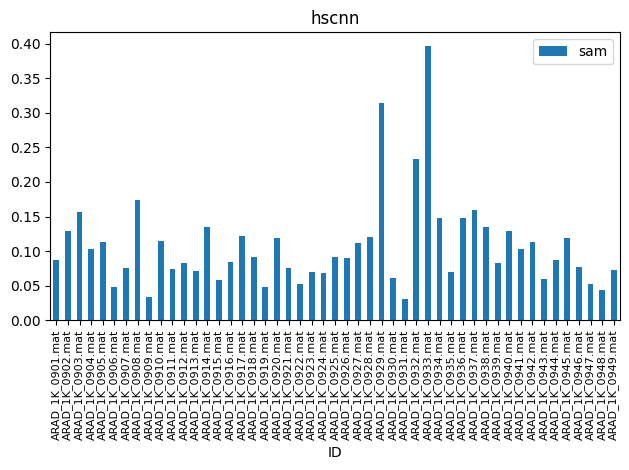

<Figure size 1200x1800 with 0 Axes>

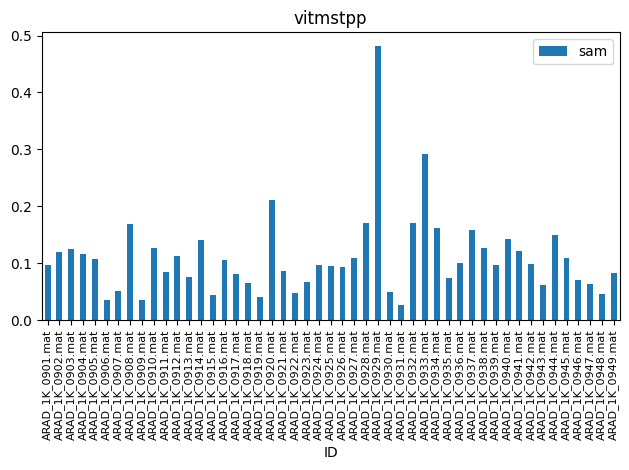

<Figure size 1200x1800 with 0 Axes>

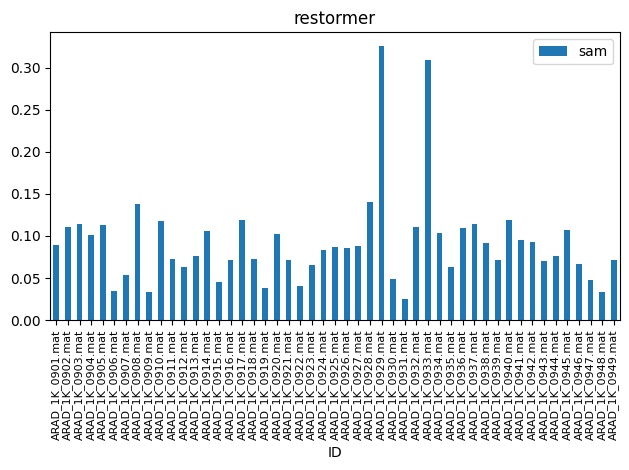

<Figure size 1200x1800 with 0 Axes>

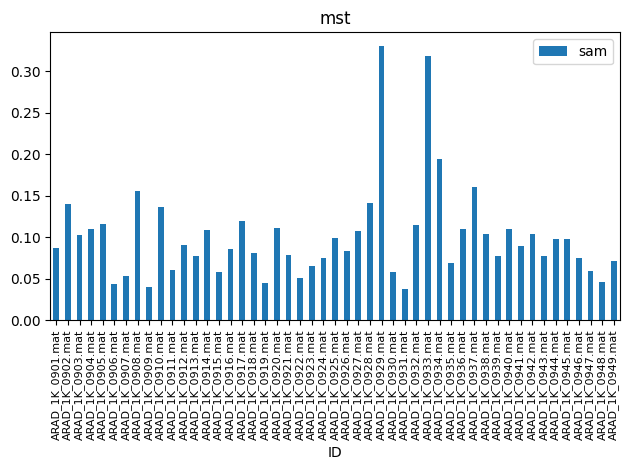

In [34]:
all_archs = ['hscnn', 'vitmstpp', 'restormer', 'mst']
#fig, axs = plt.subplots(3, 1, figsize=(8, 12))
all_dicts = {}
for j, my_arch in enumerate(all_archs):
    std_dict = {}
    mn_dict = {}
    mini_df = df[df['arch']==my_arch]

    cols = ['sam', 'ssim']
    for col in cols: 
        std_dict[col] = np.std(np.array(mini_df[col]))
        mn_dict[col] = np.mean(np.array(mini_df[col]))

    all_dicts[my_arch] = {'std':std_dict, 
                          'mean': mn_dict}
    plt.figure(figsize=(12,18))
    axs = mini_df.plot.bar(x='ID', y='sam', rot=90, subplots=False, title=my_arch)
    plt.xticks(fontsize=8)
    plt.savefig(my_arch + '_sam_dist.png')
    plt.tight_layout()

plt.show()

In [41]:
other_archs = ['hscnn', 'restormer', 'mst']
stat_columns = ['sam', 'ssim', 'mrae', 'rmse', 'psnr']
wilcox_dict = {}
greater_than_005 = {}

for arch in other_archs:
    wilcox_dict[arch+'-vitmstpp'] = {} 
    greater_than_005[arch+'-vitmstpp'] = {} 

    for col in stat_columns:

        #print(df[df['arch']=='vitmstpp'].sort_values(by='ID'))
        #print(df[df['arch']==arch].sort_values(by='ID'))

        #sorting 
        vit_col = np.array(df[df['arch']=='vitmstpp'].sort_values(by='ID')[col])
        arc_col = np.array(df[df['arch']==arch].sort_values(by='ID')[col])

        wilcox_dict[arch+'-vitmstpp'][col] = wilcoxon(vit_col,arc_col).pvalue
        greater_than_005[arch+'-vitmstpp'][col] = wilcox_dict[arch+'-vitmstpp'][col] >0.05


In [42]:
wilcox_dict

{'hscnn-vitmstpp': {'sam': 0.6359049831816286,
  'ssim': 1.427514924046136e-07,
  'mrae': 0.010313875523515037,
  'rmse': 1.2160959077078815e-05,
  'psnr': 1.7085923182946772e-06},
 'restormer-vitmstpp': {'sam': 2.065364334669084e-06,
  'ssim': 6.627983495377521e-08,
  'mrae': 4.523108358966965e-07,
  'rmse': 5.589757228818826e-05,
  'psnr': 2.2130415157306516e-05},
 'mst-vitmstpp': {'sam': 0.08905527743770847,
  'ssim': 3.6672772552037713e-07,
  'mrae': 1.6015611617348213e-05,
  'rmse': 0.00038625312302187353,
  'psnr': 0.0004971427826312436}}

In [43]:
pd.DataFrame.from_dict(greater_than_005).T

,sam,ssim,mrae,rmse,psnr
hscnn-vitmstpp,True,False,False,False,False
restormer-vitmstpp,False,False,False,False,False
mst-vitmstpp,True,False,False,False,False
